<a href="https://colab.research.google.com/github/kiseonjeong/computer-vision/blob/main/flower_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 1s 0us/step


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


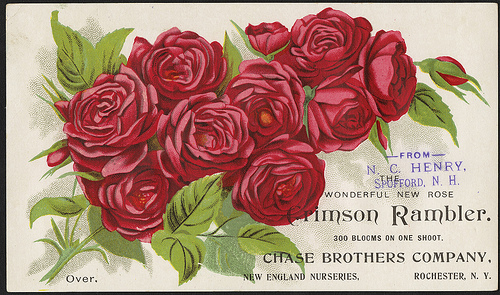

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

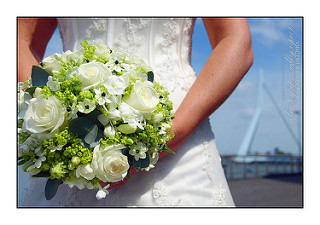

In [5]:
PIL.Image.open(str(roses[1]))

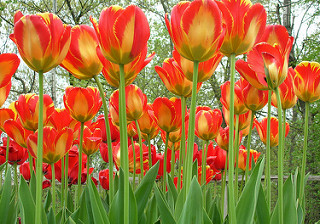

In [6]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

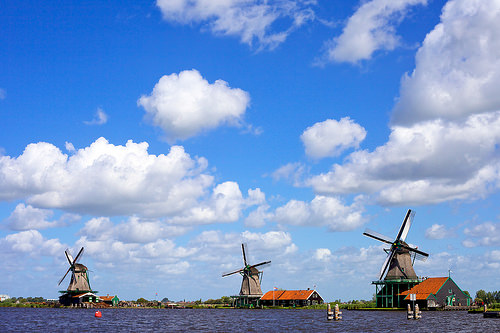

In [7]:
PIL.Image.open(str(tulips[1]))

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
print(data_dir)

/root/.keras/datasets/flower_photos


In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


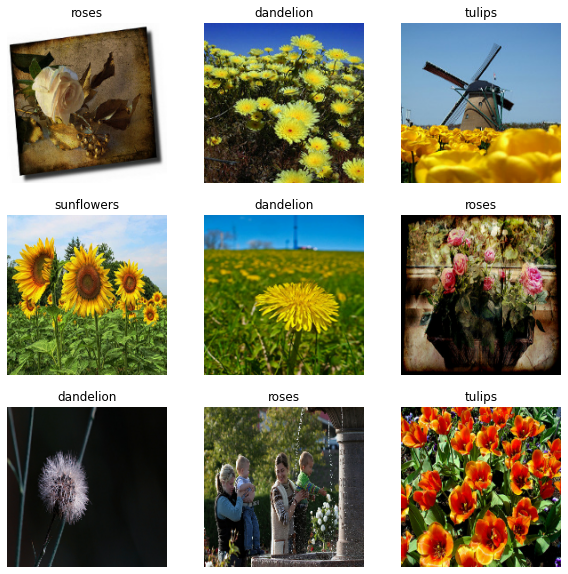

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [18]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 13s 37ms/step - loss: 1.3441 - accuracy: 0.4373 - val_loss: 1.0765 - val_accuracy: 0.5804
Epoch 2/10
92/92 [==============================] - 2s 23ms/step - loss: 0.9779 - accuracy: 0.6178 - val_loss: 0.9792 - val_accuracy: 0.6158
Epoch 3/10
92/92 [==============================] - 2s 23ms/step - loss: 0.7761 - accuracy: 0.7050 - val_loss: 0.9674 - val_accuracy: 0.6199
Epoch 4/10
92/92 [==============================] - 2s 23ms/step - loss: 0.5927 - accuracy: 0.7834 - val_loss: 1.0364 - val_accuracy: 0.6322
Epoch 5/10
92/92 [==============================] - 2s 23ms/step - loss: 0.3718 - accuracy: 0.8685 - val_loss: 1.1551 - val_accuracy: 0.6172
Epoch 6/10
92/92 [==============================] - 2s 23ms/step - loss: 0.2561 - accuracy: 0.9179 - val_loss: 1.2692 - val_accuracy: 0.6308
Epoch 7/10
92/92 [==============================] - 2s 23ms/step - loss: 0.1315 - accuracy: 0.9601 - val_loss: 1.5038 - val_accuracy: 0.6226
Epoch 8/10
9

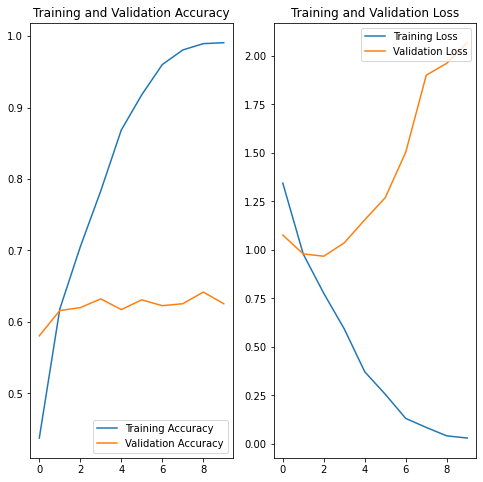

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

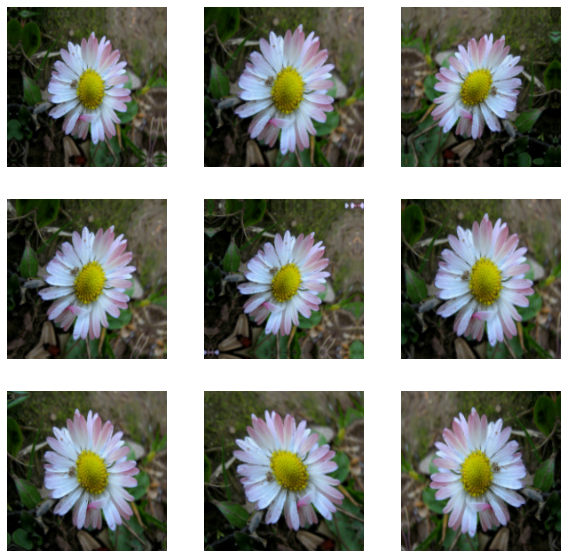

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [25]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 4s 27ms/step - loss: 1.2943 - accuracy: 0.4281 - val_loss: 1.1147 - val_accuracy: 0.5245
Epoch 2/15
92/92 [==============================] - 2s 26ms/step - loss: 1.0515 - accuracy: 0.5749 - val_loss: 1.0337 - val_accuracy: 0.5777
Epoch 3/15
92/92 [==============================] - 2s 25ms/step - loss: 0.9509 - accuracy: 0.6291 - val_loss: 0.9470 - val_accuracy: 0.6253
Epoch 4/15
92/92 [==============================] - 2s 26ms/step - loss: 0.8830 - accuracy: 0.6683 - val_loss: 0.9479 - val_accuracy: 0.6417
Epoch 5/15
92/92 [==============================] - 2s 26ms/step - loss: 0.8269 - accuracy: 0.6914 - val_loss: 0.8630 - val_accuracy: 0.6730
Epoch 6/15
92/92 [==============================] - 2s 25ms/step - loss: 0.7669 - accuracy: 0.7125 - val_loss: 0.8613 - val_accuracy: 0.6635
Epoch 7/15
92/92 [==============================] - 2s 25ms/step - loss: 0.7190 - accuracy: 0.7234 - val_loss: 0.7729 - val_accuracy: 0.7098
Epoch 8/15
92

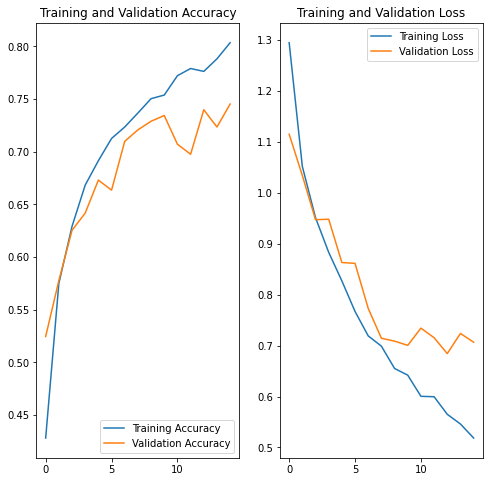

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

131072/117948 [=================================] - 0s 0us/step
This image most likely belongs to sunflowers with a 99.64 percent confidence.


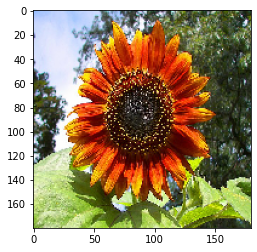

In [34]:
plt.imshow(img_array[0] / 255)
plt.show()

In [44]:
import cv2 as cv

print(img_array[0].numpy().astype('uint8'))
cv.imwrite('sunflower.jpg', img_array[0].numpy().astype('uint8'))

for images, labels in val_ds.take(1):
  for i in range(9):
    cv.imwrite(class_names[labels[i]] + str(i) + '.jpg', images[i].numpy().astype("uint8"))

[[[151 189 252]
  [152 190 253]
  [154 190 252]
  ...
  [ 49  68  49]
  [123 124 129]
  [ 27   6  15]]

 [[154 192 255]
  [155 191 253]
  [156 192 254]
  ...
  [ 34  61  28]
  [ 29  75  49]
  [ 27  71  44]]

 [[158 194 255]
  [155 191 253]
  [158 192 253]
  ...
  [ 44  53  24]
  [ 39  62  36]
  [ 35  57  34]]

 ...

 [[124 166  56]
  [123 164  62]
  [172 209 113]
  ...
  [ 48  60  50]
  [ 36  50  25]
  [ 70  87  42]]

 [[169 219  98]
  [129 175  66]
  [116 160  49]
  ...
  [ 50  62  48]
  [ 34  51  33]
  [ 38  56  40]]

 [[112 168  33]
  [125 176  55]
  [114 162  44]
  ...
  [ 43  56  36]
  [ 41  55  32]
  [ 42  56  43]]]


In [45]:
model.save('data/flower_classification')

INFO:tensorflow:Assets written to: data/flower_classification/assets
